In [81]:
from collections import OrderedDict
import re
import os
import sys

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import einops
from fancy_einsum import einsum
from tqdm.notebook import tqdm
from transformer_lens.HookedTransformer import HookedTransformer, HookedTransformerConfig

sys.path.append('Automatic-Circuit-Discovery/acdc/icl/src') 
from eval import get_run_metrics, read_run_dir, get_model_from_run
from plot_utils import basic_plot, collect_results, relevant_model_names

from samplers import get_data_sampler
from tasks import get_task_sampler

%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set_theme('notebook', 'darkgrid')
palette = sns.color_palette('colorblind')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load GPT-2 with the original weights

In [2]:
run_dir = "Automatic-Circuit-Discovery/acdc/icl/models"

task = "linear_regression"

run_id = "pretrained"  # if you train more models, replace with the run_id from the table above

run_path = os.path.join(run_dir, task, run_id)
recompute_metrics = False

if recompute_metrics:
    get_run_metrics(run_path)  # these are normally precomputed at the end of training

In [3]:
model, conf = get_model_from_run(run_path)
conf

Munch({'config': 'conf/linear_regression.yaml', 'inherit': ['base.yaml'], 'model': Munch({'family': 'gpt2', 'n_dims': 20, 'n_embd': 256, 'n_head': 8, 'n_layer': 12, 'n_positions': 101}), 'out_dir': '../models/linear_regression', 'test_run': False, 'training': Munch({'batch_size': 64, 'curriculum': Munch({'dims': Munch({'end': 20, 'inc': 1, 'interval': 2000, 'start': 5}), 'points': Munch({'end': 41, 'inc': 2, 'interval': 2000, 'start': 11})}), 'data': 'gaussian', 'keep_every_steps': 100000, 'learning_rate': 0.0001, 'num_tasks': None, 'resume_id': None, 'save_every_steps': 1000, 'task': 'linear_regression', 'task_kwargs': Munch({}), 'train_steps': 500001}), 'wandb': Munch({'entity': 'in-context', 'log_every_steps': 100, 'name': 'linear_regression_pretrained', 'notes': '', 'project': 'in-context-training'})})

In [4]:
model

TransformerModel(
  (_read_in): Linear(in_features=20, out_features=256, bias=True)
  (_backbone): GPT2Model(
    (wte): Embedding(50257, 256)
    (wpe): Embedding(202, 256)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
        )
        (ln_2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  )
  (_read_out): Linear(in_features=256, out_features=1, bias=True)
)

## Convert original parameters to Hooked Transformer state dict format

In [5]:
def convert_gpt2_weights(gpt2, cfg: HookedTransformerConfig):
    state_dict = {}

    state_dict["embed.W_E"] = gpt2._backbone.wte.weight
    state_dict["pos_embed.W_pos"] = gpt2._backbone.wpe.weight

    for l in range(cfg.n_layers):
        state_dict[f"blocks.{l}.ln1.w"] = gpt2._backbone.h[l].ln_1.weight
        state_dict[f"blocks.{l}.ln1.b"] = gpt2._backbone.h[l].ln_1.bias
        
        # In GPT-2, q,k,v are produced by one big linear map, whose output is
        # concat([q, k, v])
        W = gpt2._backbone.h[l].attn.c_attn.weight
        W_Q, W_K, W_V = torch.tensor_split(W, 3, dim=1)
        W_Q = einops.rearrange(W_Q, "m (i h)->i m h", i=cfg.n_heads)
        W_K = einops.rearrange(W_K, "m (i h)->i m h", i=cfg.n_heads)
        W_V = einops.rearrange(W_V, "m (i h)->i m h", i=cfg.n_heads)

        state_dict[f"blocks.{l}.attn.W_Q"] = W_Q
        state_dict[f"blocks.{l}.attn.W_K"] = W_K
        state_dict[f"blocks.{l}.attn.W_V"] = W_V

        qkv_bias = gpt2._backbone.h[l].attn.c_attn.bias
        qkv_bias = einops.rearrange(
            qkv_bias,
            "(qkv index head)->qkv index head",
            qkv=3,
            index=cfg.n_heads,
            head=cfg.d_head,
        )
        state_dict[f"blocks.{l}.attn.b_Q"] = qkv_bias[0]
        state_dict[f"blocks.{l}.attn.b_K"] = qkv_bias[1]
        state_dict[f"blocks.{l}.attn.b_V"] = qkv_bias[2]

        W_O = gpt2._backbone.h[l].attn.c_proj.weight
        W_O = einops.rearrange(W_O, "(i h) m->i h m", i=cfg.n_heads)
        state_dict[f"blocks.{l}.attn.W_O"] = W_O
        state_dict[f"blocks.{l}.attn.b_O"] = gpt2._backbone.h[l].attn.c_proj.bias

        
        state_dict[f"blocks.{l}.ln2.w"] = gpt2._backbone.h[l].ln_2.weight
        state_dict[f"blocks.{l}.ln2.b"] = gpt2._backbone.h[l].ln_2.bias
        
        W_in = gpt2._backbone.h[l].mlp.c_fc.weight
        state_dict[f"blocks.{l}.mlp.W_in"] = W_in
        state_dict[f"blocks.{l}.mlp.b_in"] = gpt2._backbone.h[l].mlp.c_fc.bias
        
        W_out = gpt2._backbone.h[l].mlp.c_proj.weight
        state_dict[f"blocks.{l}.mlp.W_out"] = W_out
        state_dict[f"blocks.{l}.mlp.b_out"] = gpt2._backbone.h[l].mlp.c_proj.bias


    state_dict["ln_final.w"] = gpt2._backbone.ln_f.weight
    state_dict["ln_final.b"] = gpt2._backbone.ln_f.bias

    
    return state_dict

In [6]:
toy_config = HookedTransformerConfig(
        d_model = conf.model.n_embd,
        d_head = 32,
        d_vocab = 50257,
        n_layers = conf.model.n_layer,
        n_heads = conf.model.n_head,
        n_ctx = 2 * conf.model.n_positions,
        act_fn = 'gelu_new',
        init_weights = False
    )

converted_state_dict = convert_gpt2_weights(model, toy_config)

In [7]:
for key in converted_state_dict:
    print(key)

embed.W_E
pos_embed.W_pos
blocks.0.ln1.w
blocks.0.ln1.b
blocks.0.attn.W_Q
blocks.0.attn.W_K
blocks.0.attn.W_V
blocks.0.attn.b_Q
blocks.0.attn.b_K
blocks.0.attn.b_V
blocks.0.attn.W_O
blocks.0.attn.b_O
blocks.0.ln2.w
blocks.0.ln2.b
blocks.0.mlp.W_in
blocks.0.mlp.b_in
blocks.0.mlp.W_out
blocks.0.mlp.b_out
blocks.1.ln1.w
blocks.1.ln1.b
blocks.1.attn.W_Q
blocks.1.attn.W_K
blocks.1.attn.W_V
blocks.1.attn.b_Q
blocks.1.attn.b_K
blocks.1.attn.b_V
blocks.1.attn.W_O
blocks.1.attn.b_O
blocks.1.ln2.w
blocks.1.ln2.b
blocks.1.mlp.W_in
blocks.1.mlp.b_in
blocks.1.mlp.W_out
blocks.1.mlp.b_out
blocks.2.ln1.w
blocks.2.ln1.b
blocks.2.attn.W_Q
blocks.2.attn.W_K
blocks.2.attn.W_V
blocks.2.attn.b_Q
blocks.2.attn.b_K
blocks.2.attn.b_V
blocks.2.attn.W_O
blocks.2.attn.b_O
blocks.2.ln2.w
blocks.2.ln2.b
blocks.2.mlp.W_in
blocks.2.mlp.b_in
blocks.2.mlp.W_out
blocks.2.mlp.b_out
blocks.3.ln1.w
blocks.3.ln1.b
blocks.3.attn.W_Q
blocks.3.attn.W_K
blocks.3.attn.W_V
blocks.3.attn.b_Q
blocks.3.attn.b_K
blocks.3.attn.b_V
bl

### Load a HookedTransformer with the config of the original params

In [8]:
toy_model = HookedTransformer(cfg=toy_config)
toy_model

HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0-11): 12 x TransformerBlock(
      (ln1): LayerNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): LayerNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (mlp): MLP(
        (hook_pre): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_attn_out): HookPoint()
      (hook_mlp_out): HookPoint()
      (hook_re

## Load state dict in EasyTransformer for custom Unembed

### Load the original model

In [9]:
original_state_path = os.path.join(run_path, "state.pt")
original_state = torch.load(original_state_path, map_location='cpu')["model_state_dict"]


# elements are the keys to this dict of weights
for element in original_state:
    print(element)


#Output just for reference of what we have in original gpt

_read_in.weight
_read_in.bias
_backbone.wte.weight
_backbone.wpe.weight
_backbone.h.0.ln_1.weight
_backbone.h.0.ln_1.bias
_backbone.h.0.attn.bias
_backbone.h.0.attn.masked_bias
_backbone.h.0.attn.c_attn.weight
_backbone.h.0.attn.c_attn.bias
_backbone.h.0.attn.c_proj.weight
_backbone.h.0.attn.c_proj.bias
_backbone.h.0.ln_2.weight
_backbone.h.0.ln_2.bias
_backbone.h.0.mlp.c_fc.weight
_backbone.h.0.mlp.c_fc.bias
_backbone.h.0.mlp.c_proj.weight
_backbone.h.0.mlp.c_proj.bias
_backbone.h.1.ln_1.weight
_backbone.h.1.ln_1.bias
_backbone.h.1.attn.bias
_backbone.h.1.attn.masked_bias
_backbone.h.1.attn.c_attn.weight
_backbone.h.1.attn.c_attn.bias
_backbone.h.1.attn.c_proj.weight
_backbone.h.1.attn.c_proj.bias
_backbone.h.1.ln_2.weight
_backbone.h.1.ln_2.bias
_backbone.h.1.mlp.c_fc.weight
_backbone.h.1.mlp.c_fc.bias
_backbone.h.1.mlp.c_proj.weight
_backbone.h.1.mlp.c_proj.bias
_backbone.h.2.ln_1.weight
_backbone.h.2.ln_1.bias
_backbone.h.2.attn.bias
_backbone.h.2.attn.masked_bias
_backbone.h.2.att

Visualize some original model shapes

In [11]:
print(original_state['_backbone.wte.weight'].shape,
      original_state['_read_in.weight'].shape,
      original_state['_read_in.bias'].shape,
      original_state['_read_out.weight'].shape,
      original_state['_read_out.bias'].shape
     )

torch.Size([50257, 256]) torch.Size([256, 20]) torch.Size([256]) torch.Size([1, 256]) torch.Size([1])


In [12]:
original_state['_backbone.wpe.weight'].shape

torch.Size([202, 256])

In [13]:
original_state['_backbone.wte.weight'].shape

torch.Size([50257, 256])

## Load converted parameters (state dict) into HookedTransformer

In [14]:
toy_model.load_and_process_state_dict(converted_state_dict)

In [15]:
toy_model

HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0-11): 12 x TransformerBlock(
      (ln1): LayerNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): LayerNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (mlp): MLP(
        (hook_pre): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_attn_out): HookPoint()
      (hook_mlp_out): HookPoint()
      (hook_re

In [16]:
toy_model.W_E.shape

torch.Size([50257, 256])

### Reassign unembed module

What happens here?

original weight_in: (256, 20)
original bias in: (256)

original embedder: (50257, 256)

original weight_out: (1, 256) 
original bias_out: (1)

We have an unembedder at (256, 50257), but we need matrix from 256 to 1 and then bias

In [17]:
new_unembed = nn.Linear(toy_config.d_model, 1)
new_unembed.weight = torch.nn.Parameter(original_state['_read_out.weight'])

# Assign biases
# Your biases tensor should have the shape [out_features]
new_unembed.bias = torch.nn.Parameter(original_state['_read_out.bias'])

In [18]:
toy_model.unembed = new_unembed

To add intial layer will have to modify the function that generates the data since I can't redefine HookedTransformer

### Original module bypasses embds with inputs_embeds, but HookedTransformer does not have that option. We instead replace the embed layer with an inoffensive feedforward layer

In [19]:
class PassThroughEmbed(nn.Module):
    def __init__(self, cfg=None):
        super().__init__()
        # No parameters needed, but constructor accepts cfg for compatibility

    def forward(self, tokens):
        # Directly return the input without any modifications
        return tokens

pass_through_embed = PassThroughEmbed(cfg=toy_config)

# Replace the model's embed module with pass_through_embed
toy_model.embed = pass_through_embed

## Use the model

In [21]:
# Load data

# model, conf = get_model_from_run(run_path)

n_dims = conf.model.n_dims
batch_size = conf.training.batch_size

data_sampler = get_data_sampler(conf.training.data, n_dims)
task_sampler = get_task_sampler(
    conf.training.task,
    n_dims,
    batch_size,
    **conf.training.task_kwargs
)

In [22]:
task = task_sampler()
xs = data_sampler.sample_xs(b_size=batch_size, n_points=conf.training.curriculum.points.end) # should be n_points=conf.training.curriculum.points.end, but has been hacked to work for the max_len of 101 (202)
ys = task.evaluate(xs)

In [23]:
xs.shape

torch.Size([64, 41, 20])

In [24]:
ys.shape

torch.Size([64, 41])

In [82]:
# the original model first merges the sequences in z, which we do here (z can have all but the last y since it's causal and intermediate ys are for icl and later icl lenght eval

read_in_weight = original_state['_read_in.weight']
read_in_bias = original_state['_read_in.bias']

batch, n_ctx, d_xs = xs.shape

ys_wide = torch.cat(
    (
        ys.view(batch, n_ctx, 1),
        torch.zeros(batch, n_ctx, d_xs - 1, device=ys.device),
    ),
    axis=2,
)
my_zs = torch.stack((xs, ys_wide), dim=2)
my_zs = my_zs.view(batch, 2 * n_ctx, d_xs)

# apply the read_in transformation
transformed_zs = einsum("batch n_ctx d_xs, d_model d_xs -> batch n_ctx d_model", my_zs, read_in_weight) + read_in_bias

# apply padding
max_len = toy_config.n_ctx

current_len = transformed_zs.shape[1]

pad_len = max(max_len - current_len, 0)

# Apply padding to the right of the second dimension
# The padding order in F.pad is (left, right, top, bottom) for 4D input, but here it's the equivalent for 3D
padded_transformed_zs = F.pad(transformed_zs, (0, 0, 0, pad_len), "constant", 0)

In [86]:
padded_transformed_zs.shape

torch.Size([64, 202, 256])

In [87]:
with torch.no_grad():
    my_pred = toy_model(padded_transformed_zs)[:, ::2, 0][:, torch.arange(ys.shape[1])] # this last transformation before returning is in the original and I assume only selects the predictions for ys

In [63]:
transformed_zs.shape

torch.Size([64, 82, 256])

In [77]:
original_gpt2_pred = model._backbone(inputs_embeds=transformed_zs).last_hidden_state

In [78]:
original_final_preds = model._read_out(original_gpt2_pred)

In [79]:
original_final_preds.shape

torch.Size([64, 82, 1])

In [65]:
model._backbone.wpe

Embedding(202, 256)

In [64]:
model._backbone

GPT2Model(
  (wte): Embedding(50257, 256)
  (wpe): Embedding(202, 256)
  (drop): Dropout(p=0.0, inplace=False)
  (h): ModuleList(
    (0-11): 12 x GPT2Block(
      (ln_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2Attention(
        (c_attn): Conv1D()
        (c_proj): Conv1D()
        (attn_dropout): Dropout(p=0.0, inplace=False)
        (resid_dropout): Dropout(p=0.0, inplace=False)
      )
      (ln_2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D()
        (c_proj): Conv1D()
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
)

In [60]:
pred.shape

NameError: name 'pred' is not defined

In [127]:
final_pred = pred[:, ::2, 0][:, torch.arange(ys.shape[1])]

In [128]:
final_pred.shape

torch.Size([64, 101])

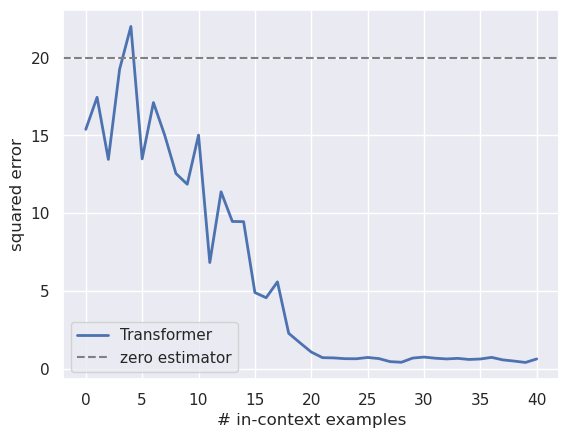

In [88]:
metric = task.get_metric()
loss = metric(my_pred, ys).numpy()

sparsity = conf.training.task_kwargs.sparsity if "sparsity" in conf.training.task_kwargs else None
baseline = {
    "linear_regression": n_dims,
}[conf.training.task]

plt.plot(loss.mean(axis=0), lw=2, label="Transformer")
plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()

### now for reference, the original model performance

In [56]:
with torch.no_grad():
    original_pred = model(xs, ys)

In [57]:
original_pred.shape

torch.Size([64, 41])

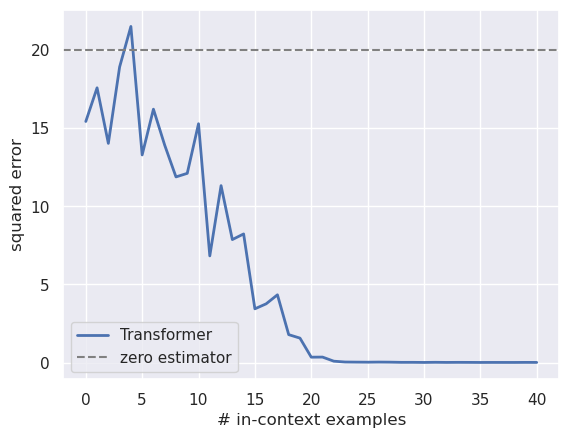

In [58]:
metric = task.get_metric()
loss = metric(original_pred, ys).numpy()

sparsity = conf.training.task_kwargs.sparsity if "sparsity" in conf.training.task_kwargs else None
baseline = {
    "linear_regression": n_dims,
    "sparse_linear_regression": sparsity,
    "relu_2nn_regression": n_dims,
    "decision_tree": 1,
}[conf.training.task]

plt.plot(loss.mean(axis=0), lw=2, label="Transformer")
plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()